# Introduction


In this notebook I will be trying creating correlation matrices and correlation networks from the SP500 data. I will also look a robust versions of correlation matrices.  The marketwide effect and the random noise, should be filtered out. That is, we have will be able to identify groups of stocks that are highly correlated after taking the market correlation out of the equation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.linalg import eigh

# Calculating the Correlation matrix

We start by calculating the correlation matrix. We will only consider data from 2011-01-01 until 2021-08-15

In [4]:

min_date = '2004-01-01 04:00:00'
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')


In [5]:
C = price_pivot.dropna(axis =1).corr()

# Localization of Eigenvectors

Let's eaxamine  the eigenvectors. Only a few components contribute to each eigenvector, and the stocks corresponding to those dominant components of the eigenvector are usually found to belong to a common industry. We can test this by doing a simple plot. 

In [6]:
# Eigen decomposition

w, V = eigh(C)
w = np.flipud(w)
V = np.fliplr(V)


In [4]:
V_df = pd.DataFrame(V)
V_df['ticker'] = C.index
V_df = pd.merge(V_df, asset_profiles, on = 'ticker')
V_df = V_df.sort_values(by = 'sector' )

V_df['change'] = 0
V_df['index'] = range(V_df.shape[0])
last = ''
tick = []
tick_sector = []
for i in range(V_df.shape[0]-1):
    if V_df['sector'].iloc[i] != V_df['sector'].iloc[i+1]:
       # print(f"{V_df['sector'].iloc[i]}  {V_df['sector'].iloc[i+1]}")
        V_df.loc[i, 'change'] = 1
        tick.append(i)
        tick_sector.append(V_df['sector'].iloc[i])
    if i == V_df.shape[0]-2:
        V_df.loc[i, 'change'] = 1
        tick.append(i)
        tick_sector.append(V_df['sector'].iloc[i])




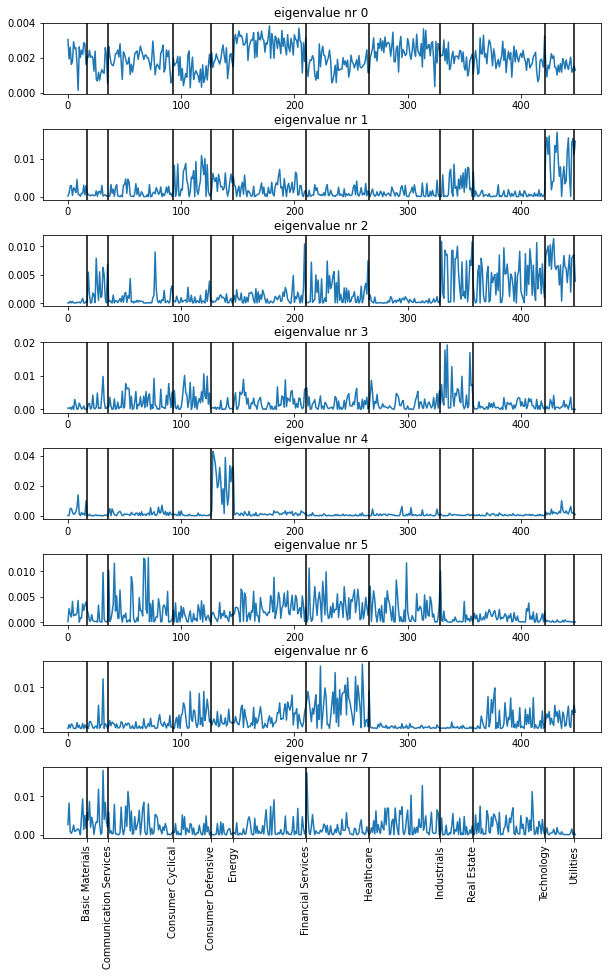

In [5]:
nr_eigen = 8

fig, ax = plt.subplots(nr_eigen, 1, figsize=(10, 15))

plt.title('The eigenvalues squared.')

for i in range(nr_eigen):
    V_plot = V_df.iloc[:,i]
   
    ax[i].plot(range(len(V_plot)), np.abs(V_plot) ** 2)
    for j in tick:
        ax[i].axvline(j, color = 'black')
    ax[i].set_title(f'eigenvalue nr {i}')

    if i == nr_eigen -1:
        ax[i].set_xticks(tick)
        ax[i].set_xticklabels(tick_sector, rotation = 90)

fig.subplots_adjust(hspace=.5)

The figure shows the eigenvalues entries squared. We see that the first eigenvector, which corresponds to the marketwide effect, has not real dominant values. The other eigenvector, however, seem to have dominant eigenvalue entries which seem relate to sectors. This is especially true for eigenvector nr. 4 where we the entries correspond to the energy sector.

# Group Identification


We are interested in decomposing the correlation matrix into the market correlation $C^m$, group correlation $C^g$ and the random noise $C^n$. The idea behind group identification is pretty simple. We simply assume that the correlation matrix can be written as.

$$
\begin{aligned}
C &= C^m + C^g + C^n \\
&= \lambda_0u_0u_0^T + \sum_{i=1}^{N_g} \lambda_i u_i u_i^T + \sum_{i=N_g +1}^{N} \lambda_i u_i u_i^T
\end{aligned}
$$

Determining the market correlation is straight forward as it is simply the outer-product of the eigenvector corresponding to the largest eigenvalue. Determining $N_g$ is more difficult, but we can do it graphically. It has been shown that the bulk of the eigenvalues of the stock matrix are in remarkable agreements with the universal properties of the random correlation matrix. Therefore, we simply choose the eigenvalues that are outside of the bulk.

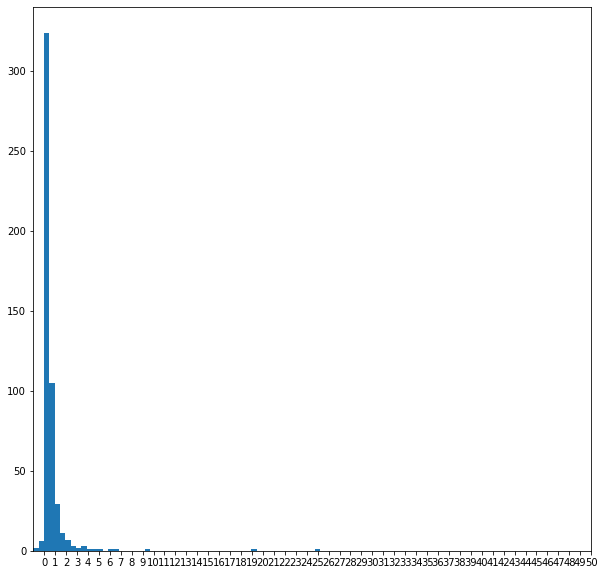

In [6]:
plt.figure(figsize =(10,10))
plt.subplot(1,1,1)
plt.hist(w, bins = 400)
plt.xlim([-1,50])
ticks = plt.xticks(range(51))

From this figure we can see that eigenvalues above $\sim$ 3 are not inside of the "bulk". So we just calculate the number of eigenvalues above 3.

In [7]:
sum(w >3)

13

Taking the largest 13 eigenvalues is ok (including the first eigenvector)

In [8]:
N_g = 12

C_m = w[0]*np.outer(V[:,0],V[:,0])
C_g = np.dot(V[:,1:(N_g+1)], np.diag(w[1:(N_g+1)])).dot(V[:,1:(N_g+1)].T)
C_g[C_g<0] = 0

Now we want to use the group correlation matrix to find the groups of stocks. The stocks in each block should be correlated but stocks between different groups should not be correlated. That is we have intra-correlation but not inter-correlation. This means that the group correlation matrix should be block diagonalizable. As an example, a group correlation matrix with 3 groups should having the following pattern:

$$C_g = \begin{bmatrix}
G_1 &  \boldsymbol{0 } & \boldsymbol{0 }\\
\boldsymbol{0 } & G_2 & \boldsymbol{0 }\\
\boldsymbol{0 } & \boldsymbol{0 } & G_3
\end{bmatrix}$$

Our current group correlation matrix, however, looks like this:


<AxesSubplot:>

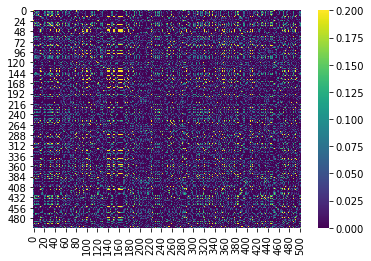

In [9]:
sns.heatmap(C_g, cmap = 'viridis', vmin = 0, vmax = 0.2 )

So to identify the groups, we need to shuffle the rows and columns until we have a block diagonal matrix. Unfortunately, that procedure is a combinatorial hard problem and with 500 stocks we have to approximate the best permutation. The authors suggested to consider an energy attraction function

$$ E = \sum_{i < j} C_{ij}^g |l_i - l_j|\boldsymbol{1} (C_{ij}^g -c_c >0)$$

where $l_i$ is the position of stock $i$ in the new index sequence. We can choose whatever cutoff $c_c$ we want. I will simply use $c_c = 0$. One optimization method that can be used to approximate combinatorial hard problem is simulated annealing. The following code creates a class that can perform our optimization task.

In [11]:
class SA:


    def __init__(self, C, step_max, temp_min, temp_start, alpha) -> None:
        self.C = C.copy()
        self.step_max = step_max
        self.temp_min = temp_min
        self.temp_start = temp_start
        self.alpha = alpha

        self.index = np.array(range(C.shape[0]))

        label = np.zeros(C.shape)
        label[range(C.shape[0]), range(C.shape[0])] = 1
        label = label.cumsum(axis=0)
        label[range(C.shape[0]), range(C.shape[0])] = 0
        self.label = label.cumsum(axis=0)


    def energy(self):
        return np.trace(np.dot(self.C, self.label))


    def move_state(self):
        """
        Randomly swap rows. 
        """
        p0 = np.random.randint(0, len(C)-1)
        p1 = np.random.randint(0, len(C)-1)
        self.C_last_state = self.C.copy()

        self.index[p0], self.index[p1] = self.index[p1], self.index[p0] 
        
        self.C[[p0,p1],:] = self.C[[p1,p0],:]
        self.C[:,[p0,p1]] = self.C[:,[p1,p0]]
        #print(self.C == self.C_last_state)

    def update_temperature(self, step):
        return self.temp_start /  (1 + self.alpha * step)


    def optimize(self):
        # begin optimizing
        step = 1
        t_step = self.temp_start
        self.best_energy = np.inf
        self.best_index = np.array(range(C.shape[0]))

        self.not_keeping = 0
        while step < self.step_max and t_step >= self.temp_min:

            current_energy = self.energy()
            self.move_state()
            new_energy = self.energy()

            dE = new_energy - current_energy
            # determine if we should not  accept the current neighbor
            # we always accept if we find a new a better energy state,

            if step % 1000 == 0:
                print(f'{step} {t_step} {-dE / t_step}')
            if np.log(np.random.uniform()) > -dE / t_step:
                self.not_keeping +=1
                self.C = self.C_last_state.copy()

            # keep track of best index
            if new_energy < self.best_energy:
                self.best_energy = new_energy
                self.best_index = self.index.copy()

                
            
            # update some stuff
            t_step = self.update_temperature(step)
            step += 1


The following code runs the optimization (which might take some time),

In [12]:
sa = SA(C = C_g.copy(), step_max = 5000, temp_min= 1, temp_start= 10000,alpha=0.1 )
sa.optimize()

1000 99.10802775024777 -1.7604441319735231
2000 49.77600796416127 1.5202046972103336
3000 33.23363243602525 -37.46126631224635
4000 24.943876278373658 11.60435458980801


<AxesSubplot:>

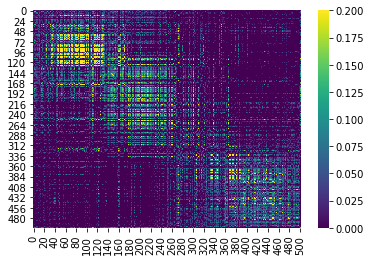

In [13]:
sns.heatmap(sa.C, cmap = 'viridis', vmin = 0, vmax = 0.2)

Let's check if certain sectors live within the same grouping.

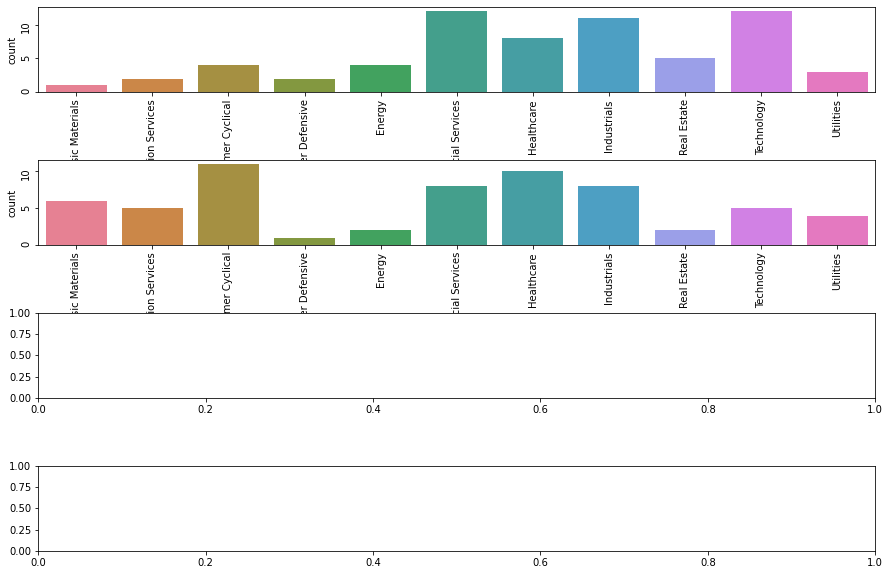

In [13]:
C_df = pd.DataFrame(C)
C_df = pd.merge(C_df, asset_profiles, left_index=True, right_on='ticker', how = 'left')
C_df['my_index'] = range(C_df.shape[0])




fig, ax = plt.subplots(4, 1, figsize=(15, 10))
index = [0,192,240, C.shape[0]]

out = sns.countplot(x = 'sector', data = C_df.iloc[sa.index[:72]].sort_values(by = 'sector'), ax = ax[0], palette = sns.color_palette("husl", 11))
ax[0].tick_params(labelrotation=90)
out = sns.countplot(x = 'sector', data = C_df.iloc[sa.index[432:]].sort_values(by = 'sector'), ax = ax[1], palette = sns.color_palette("husl", 11))
ax[1].tick_params(labelrotation=90)
# out = sns.countplot(x = 'sector', data = C_df.iloc[220:250].sort_values(by = 'sector' ), ax = ax[2], palette = sns.color_palette("husl", 11))
# ax[2].tick_params(labelrotation=90)
# out = sns.countplot(x = 'sector', data = C_df.iloc[250:290].sort_values(by = 'sector' ), ax = ax[3], palette = sns.color_palette("husl", 11))
# ax[3].tick_params(labelrotation=90)

fig.subplots_adjust(hspace=.8)




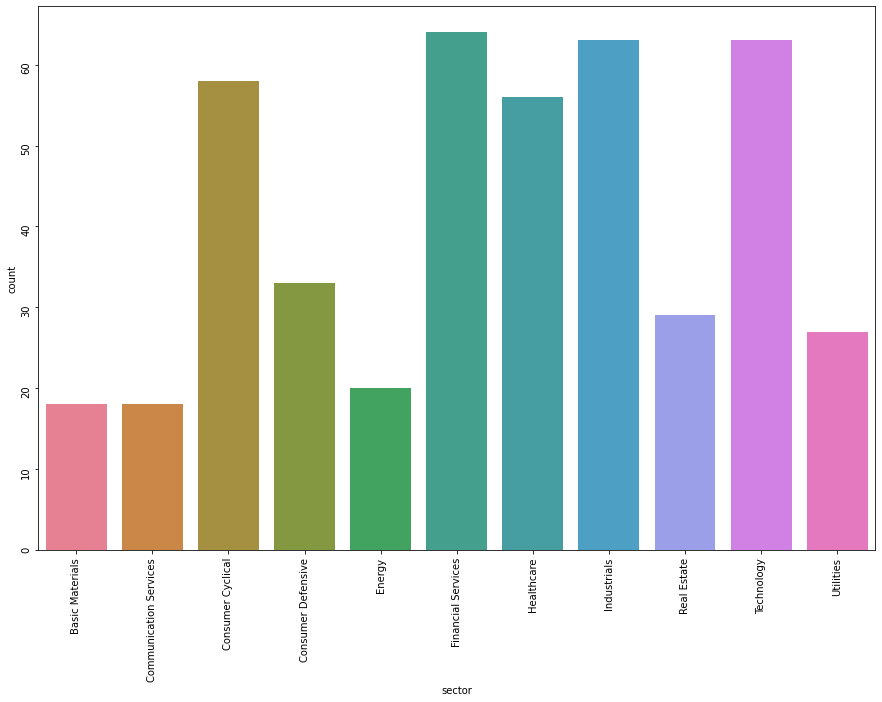

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.countplot(x = 'sector', data = C_df.sort_values(by = 'sector'), palette = sns.color_palette("husl", 11), ax = ax)
ax.tick_params(labelrotation=90)

## Let's order by sector

<AxesSubplot:>

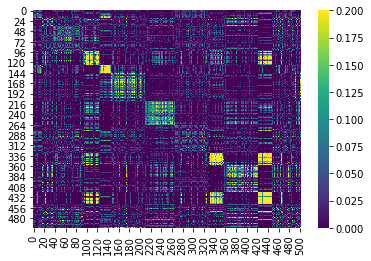

In [18]:
C_df = C_df.sort_values(by = 'sector')

p = list(C_df['my_index'])
C_g_sector = C_g.copy()
N = C_g_sector.shape[0]
for i in range(N):
    C_g_sector[:,i] = C_g_sector[p,i]
for i in range(N):
    C_g_sector[i,:] = C_g_sector[i,p]
sns.heatmap(C_g_sector, cmap = 'viridis', vmin = 0, vmax = 0.2)

In [16]:
matrix = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(matrix)
matrix[[0,1],:] = matrix[[1,0],:]
matrix[:,[0,1]] = matrix[:,[1,0]]
matrix

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[5, 4, 6],
       [2, 1, 3],
       [8, 7, 9]])

In [17]:
label = np.zeros(C.shape)
label[range(C.shape[0]), range(C.shape[0])] = 1
label = label.cumsum(axis=0)
label[range(C.shape[0]), range(C.shape[0])] = 0
label = label.cumsum(axis=0)

print(np.trace(np.dot(sa.C, label)))

print(np.trace(np.dot(C_g_sector, label)))

243846.6882000826
449499.61127649556


In [155]:
sa.C

array([[ 0.17104109,  0.06456516,  0.06991068, ..., -0.14532828,
        -0.02448426, -0.09786715],
       [ 0.06456516,  0.22229531,  0.03800621, ..., -0.11827062,
        -0.00230445, -0.10338749],
       [ 0.06991068,  0.03800621,  0.06498294, ..., -0.07392104,
        -0.06827498, -0.04418811],
       ...,
       [-0.14532828, -0.11827062, -0.07392104, ...,  0.21139806,
         0.04682801,  0.09087087],
       [-0.02448426, -0.00230445, -0.06827498, ...,  0.04682801,
         0.14189346,  0.02606929],
       [-0.09786715, -0.10338749, -0.04418811, ...,  0.09087087,
         0.02606929,  0.14917344]])